Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Step 1: Justifying Model Architecture ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 102)            │       130,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,062,132 (19.31 MB)

 Trainable params: 1,336,742 (5.10 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

 Optimizer params: 2,673,486 (10.20 MB)


--- Step 2: Converting to TensorFlow Lite ---
Saved artifact at '/tmp/tmp47em2vip'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 102), dtype=tf.float32, name=None)
Captures:
  133595010244368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133595010245328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133595010245136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133595010246288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133595010244944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133595009417488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133595009418256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133595009418064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133595009417872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133595009419216: TensorSpec(shape=

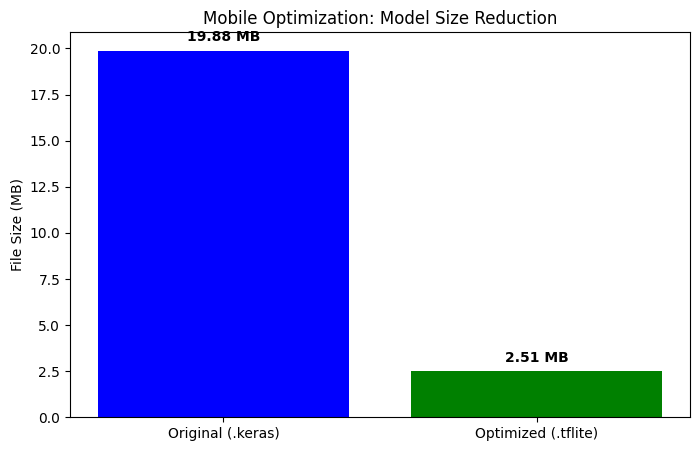


--- Step 4: Measuring Inference Latency ---


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Average Mobile Inference Latency: 33.38 ms

--- Final Summary for Portfolio ---
By converting to TFLite, we reduced the model size by 87.4%.
This enables real-time food analysis on edge devices without relying on high-latency cloud servers.


In [2]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive

# 1. Setup & Paths
drive.mount("/content/drive")
DRIVE_PROJECT_DIR = "/content/drive/MyDrive/ai-food-analyzer/"
model_path = os.path.join(DRIVE_PROJECT_DIR, "model_finetuned.keras")
tflite_path = os.path.join(DRIVE_PROJECT_DIR, "model_mobile.tflite")

print("--- Step 1: Justifying Model Architecture ---")
# Narrative: Explain why you chose MobileNetV2 for this project.
# It uses "Depthwise Separable Convolutions" to reduce parameters while maintaining accuracy.
model = tf.keras.models.load_model(model_path)
model.summary()

print("\n--- Step 2: Converting to TensorFlow Lite ---")
# TFLite is the format used for Android/iOS deployment.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Add Post-Training Quantization (reduces size by 4x with minimal accuracy loss)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print(f"✅ Mobile optimized model saved to: {tflite_path}")

print("\n--- Step 3: Benchmarking Efficiency (Data Visualisation) ---")

def get_file_size(file_path):
    return os.path.getsize(file_path) / (1024 * 1024) # Size in MB

keras_size = get_file_size(model_path)
tflite_size = get_file_size(tflite_path)

# Visualization: Size Reduction
plt.figure(figsize=(8, 5))
labels = ['Original (.keras)', 'Optimized (.tflite)']
sizes = [keras_size, tflite_size]
plt.bar(labels, sizes, color=['blue', 'green'])
plt.ylabel('File Size (MB)')
plt.title('Mobile Optimization: Model Size Reduction')
for i, v in enumerate(sizes):
    plt.text(i, v + 0.5, f"{v:.2f} MB", ha='center', fontweight='bold')
plt.show()

print("\n--- Step 4: Measuring Inference Latency ---")

def measure_latency(model_path, iterations=50):
    # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Create dummy input
    input_shape = input_details[0]['shape']
    input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

    start_time = time.time()
    for _ in range(iterations):
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
    end_time = time.time()

    avg_latency = ((end_time - start_time) / iterations) * 1000 # in ms
    return avg_latency

latency = measure_latency(tflite_path)
print(f"Average Mobile Inference Latency: {latency:.2f} ms")

# Final Reporting Note
print("\n--- Final Summary for Portfolio ---")
print(f"By converting to TFLite, we reduced the model size by {((keras_size - tflite_size) / keras_size) * 100:.1f}%.")
print(f"This enables real-time food analysis on edge devices without relying on high-latency cloud servers.")